<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-proditorIF/blob/main/Oct20-21/PCA_Espectre_McL_BRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clase 14/10/2023
## PCA aplicado  Espectro
Análisis de Componentes Principales

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
spec_file=fits.open("/content/drive/MyDrive/Machine_Learn/DESI/coadd-sv3-dark-9930.fits")

In [4]:
spec_file.info()

Filename: /content/drive/MyDrive/Machine_Learn/DESI/coadd-sv3-dark-9930.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  FIBERMAP      1 BinTableHDU    219   11R x 70C   [K, J, D, D, E, E, E, K, B, 3A, D, J, I, 8A, J, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, E, 1A, K, K, K, K, K, K, K, K, K, D, D, I, E, I, I, E, E, E, E, D, E, D, E, E]   
  2  EXP_FIBERMAP    1 BinTableHDU     64   1434R x 26C   [K, J, D, J, J, D, J, D, I, J, K, J, J, E, E, E, D, D, K, D, D, D, D, D, D, D]   
  3  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  4  B_FLUX        1 ImageHDU         8   (2751, 11)   float32   
  5  B_IVAR        1 ImageHDU         8   (2751, 11)   float32   
  6  B_MASK        1 ImageHDU        10   (2751, 11)   int32 (rescales to uint32)   
  7  B_RESOLUTION    1 ImageHDU         9   (2751, 11, 11)   float32   
  8  R_WAVELENGTH    1 ImageHDU        10  

In [5]:
#The FIBERMAP HDU contains information about the object that was observed,
# in particular we will be interested in the TARGETID, the unique identifier
# assigned to each object observed in DESI

fibermap=Table(spec_file["FIBERMAP"].data)
fibermap

<Table length=11>
     TARGETID     COADD_FIBERSTATUS ... STD_FIBER_DEC MEAN_PSF_TO_FIBER_SPECFLUX
      int64             int32       ...    float32             float32          
----------------- ----------------- ... ------------- --------------------------
39633158248860187                 0 ...    0.11946119                      0.789
39633162560603324                 0 ...    0.11754271                      0.789
39633158248858158                 0 ...    0.07084771                      0.789
39633162564798529                 0 ...      0.088835                      0.789
39633166855570067                 0 ...    0.13825908                      0.789
39633162556411118                 0 ...   0.036579233                      0.789
39633162556410465                 0 ...  0.0032049965                      0.789
39633158248859282                 0 ...           0.0                      0.789
39633158248857947                 0 ...           0.0                 0.75050825
39633158248859374                 0 ...   0.015519819                      0.789
39633166859764243                 0 ...   0.087271795                      0.789

In [6]:
#As can be seen in the table, we have spectra of 11 quasars.
#Lets save the TARGETIDs into one variable for future use
tids=fibermap["TARGETID"]

In [7]:
#Now, the spectra DESI observed for each quasar, i.e. for a given targetid,
#is saved in HDUs named  B_FLUX, R_FLUX, Z_FLUX.
#And the Wavelenght grids are in B_WAVELENGTH,B_WAVELENGTH,Z_WAVELENGTH HDUs respectively.
# B,R,Z correspond to the different bands of the DESI spectrographs.
# Lets access to the spectra, only b band for now,  and plot it.
bwave = spec_file["B_WAVELENGTH"].data
bflux =spec_file["B_FLUX"].data

In [8]:
#Now, the spectra DESI observed for each quasar, i.e. for a given targetid,
#is saved in HDUs named  B_FLUX, R_FLUX, Z_FLUX.
#And the Wavelenght grids are in B_WAVELENGTH,B_WAVELENGTH,Z_WAVELENGTH HDUs respectively.
# B,R,Z correspond to the different bands of the DESI spectrographs.
# Lets access to the spectra, only b band for now,  and plot it.
bwave = spec_file["B_WAVELENGTH"].data
bflux =spec_file["B_FLUX"].data
print(bflux.shape)

(11, 2751)


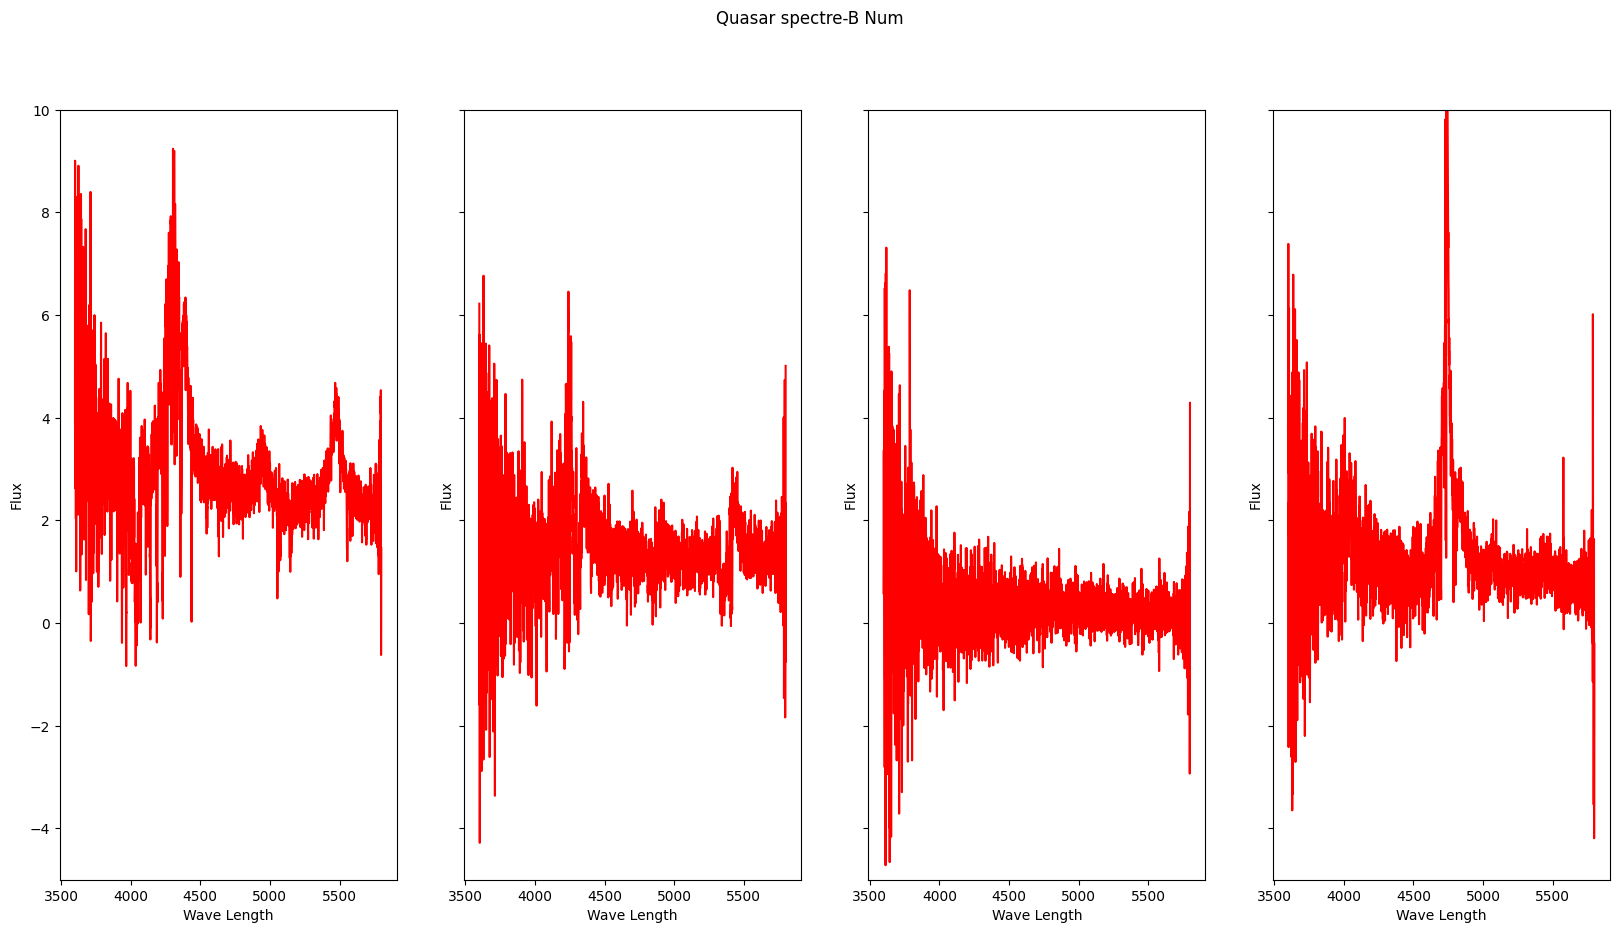

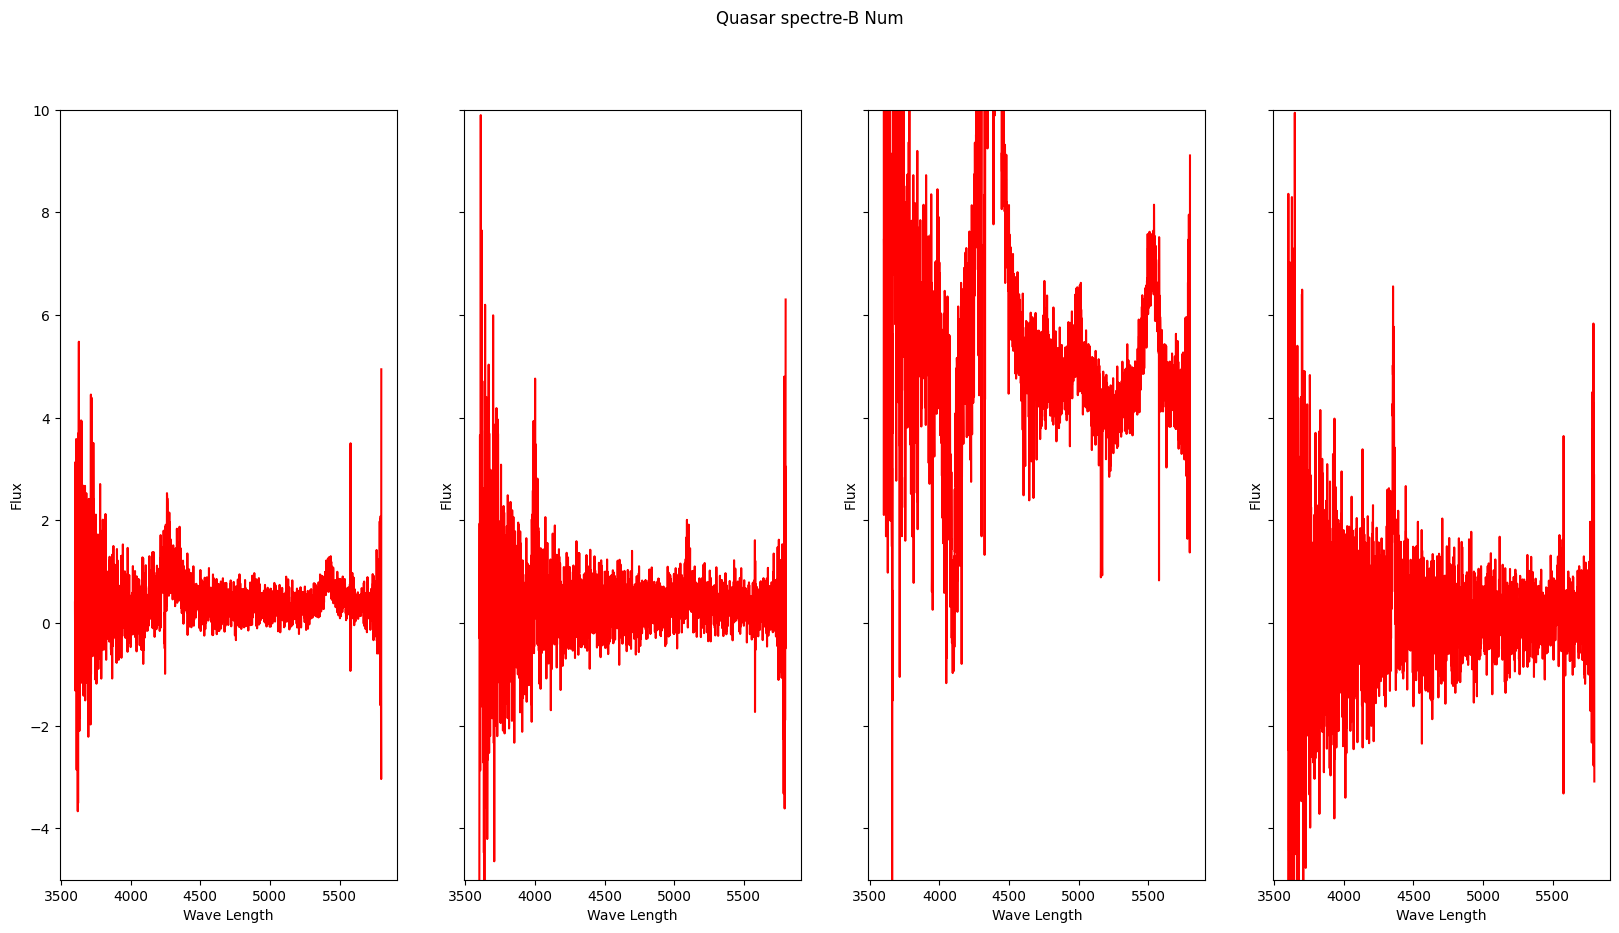

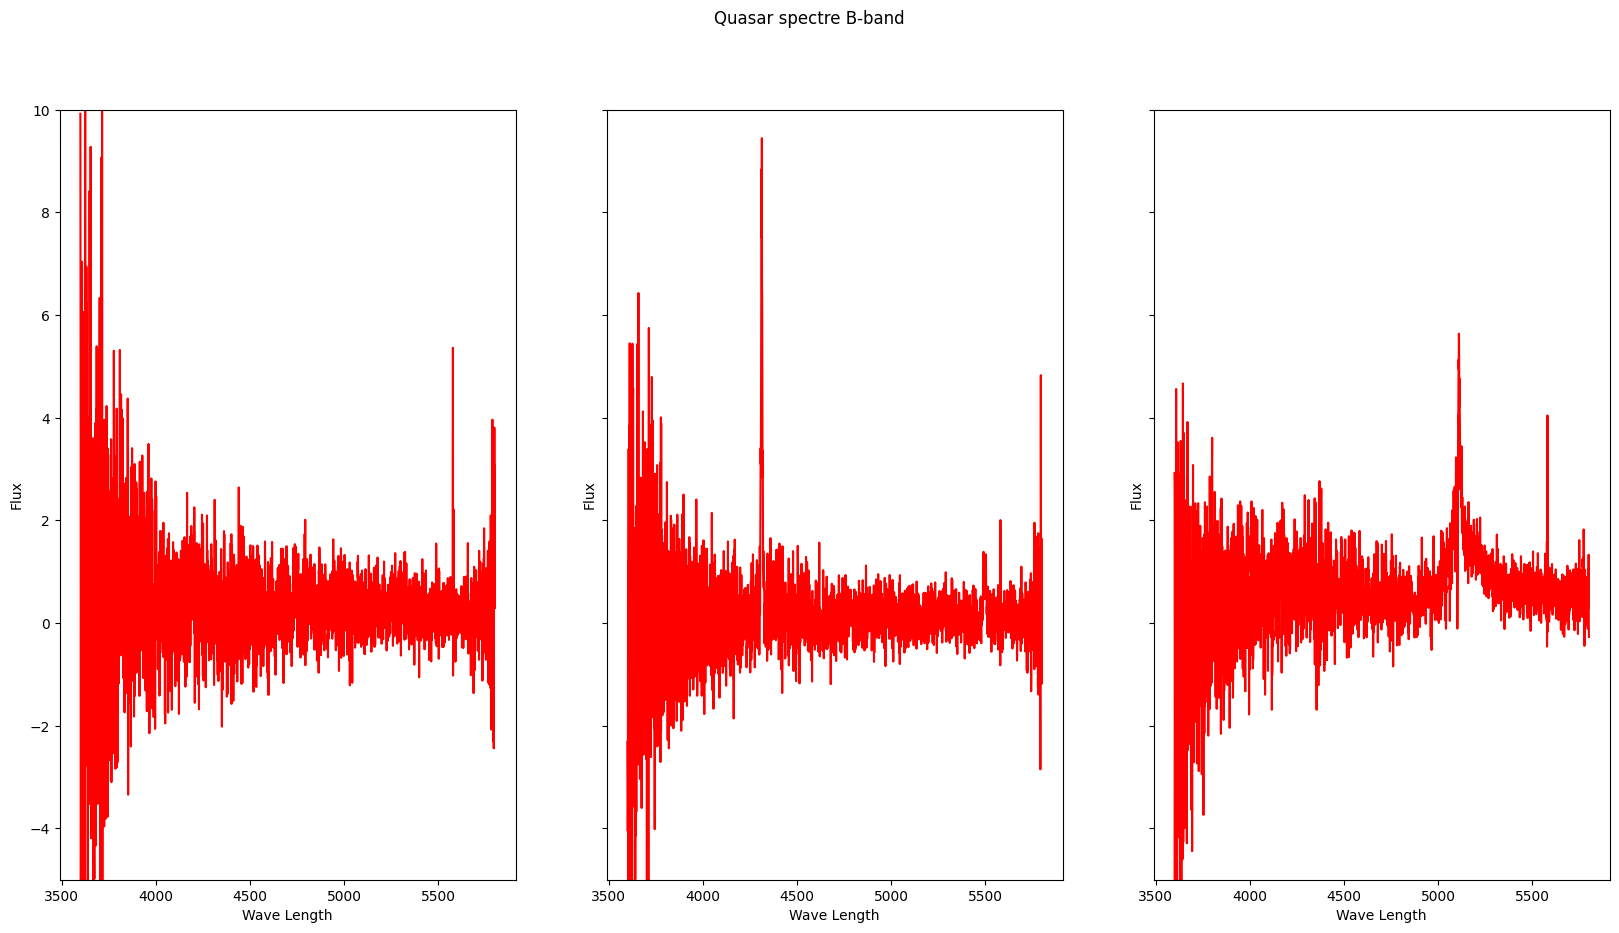

In [9]:
# Se imprimen los 11 especetros
for j in range (2):
  fig,ax=plt.subplots(1,4,figsize=(20, 10),sharey=True)
  for i in range(4):
    ax[i].plot(bwave,bflux[i+(j*4)],'red')
    plt.ylim(-5,10)
    ax[i].set_xlabel("Wave Length")
    ax[i].set_ylabel("Flux")
  fig.suptitle(f"Quasar spectre-B Num")
  plt.show()
fig,ax=plt.subplots(1,3,figsize=(20, 10),sharey=True)
for i in range(3):
  ax[i].plot(bwave,bflux[i+8],'red')
  plt.ylim(-5,10)
  ax[i].set_xlabel("Wave Length")
  ax[i].set_ylabel("Flux")
  fig.suptitle(f"Quasar spectre B-band")
plt.show()

#### Exercise: Use the PCA analysis to find the principal components that corresponds for the spectra we have. Do it first for the spectra in only one file, then combine the data from different files and make the PCA again.

In [10]:
#In this case we will read the redshift catalog as a table directly.
zcat=Table.read("/content/drive/MyDrive/Machine_Learn/DESI/zall-pix-edr-vac.fits",hdu=1)
#Display the redshift catalog.
zcat

<Table length=2451325>
     TARGETID      SURVEY PROGRAM ...    MAX_MJD     FIRSTNIGHT LASTNIGHT
      int64        bytes7  bytes6 ...    float64       int32      int32  
------------------ ------ ------- ... -------------- ---------- ---------
 39628473198708395    cmx   other ... 59200.12381137   20201216  20201216
 39628473198709499    cmx   other ... 59200.12381137   20201216  20201216
 39628473198710139    cmx   other ... 59200.12381137   20201216  20201216
 39628473198710603    cmx   other ... 59200.12381137   20201216  20201216
 39628473198711006    cmx   other ... 59200.12381137   20201216  20201216
 39628473198711342    cmx   other ... 59200.12381137   20201216  20201216
 39628473198711925    cmx   other ... 59200.12381137   20201216  20201216
 39628473202901028    cmx   other ... 59200.12381137   20201216  20201216
 39628473202901626    cmx   other ... 59200.12381137   20201216  20201216
 39628473202901945    cmx   other ... 59200.12381137   20201216  20201216
               ...    ...     ... ...            ...        ...       ...
616094220515541567    sv3    dark ...  59316.4783506   20210411  20210411
616094220515541579    sv3    dark ... 59317.49939296   20210412  20210412
616094220515541580    sv3    dark ...  59316.4783506   20210411  20210411
616094220515541610    sv3    dark ... 59311.42777604   20210406  20210406
616094220515541672    sv3    dark ... 59311.42777604   20210406  20210406
616094220515541854    sv3    dark ... 59311.42777604   20210406  20210406
616094220519735351    sv3    dark ... 59324.44062717   20210419  20210419
616094220519735611    sv3    dark ... 59312.47978586   20210407  20210407
616094220523929606    sv3    dark ... 59314.39992879   20210409  20210409
616094222814020204    sv3    dark ... 59324.44062716   20210419  20210419

In [11]:
#From the zcat table, the most important thing we will use is the TARGETID, the SURVEY, the SPECTYPE and the redshift Z.
#Lets reduce the table to just these variables.
zcat=zcat['TARGETID','SURVEY','SPECTYPE','Z']
zcat

<Table length=2451325>
     TARGETID      SURVEY SPECTYPE           Z           
      int64        bytes7  bytes6         float64        
------------------ ------ -------- ----------------------
 39628473198708395    cmx     STAR -0.0019956912923479522
 39628473198709499    cmx   GALAXY      0.797663336968385
 39628473198710139    cmx   GALAXY       1.33150513847107
 39628473198710603    cmx   GALAXY      0.804205874112604
 39628473198711006    cmx     STAR -6.607473910190775e-05
 39628473198711342    cmx     STAR -0.0019956912923479522
 39628473198711925    cmx   GALAXY    0.39072440164450306
 39628473202901028    cmx   GALAXY     0.6657999257489294
 39628473202901626    cmx   GALAXY    0.32842015807005115
 39628473202901945    cmx   GALAXY    0.35499256923949984
               ...    ...      ...                    ...
616094220515541567    sv3     STAR -0.0019956912923479522
616094220515541579    sv3   GALAXY    0.14669471589166502
616094220515541580    sv3     STAR -0.0019956912923479522
616094220515541610    sv3   GALAXY      1.625973033373096
616094220515541672    sv3   GALAXY     1.5703204313161931
616094220515541854    sv3   GALAXY     1.1443494269516812
616094220519735351    sv3   GALAXY     0.9811496704970901
616094220519735611    sv3   GALAXY     1.6382227753303393
616094220523929606    sv3     STAR -0.0019956912923479522
616094222814020204    sv3   GALAXY     0.6903148870877507

In [12]:
#Now lets reduce the table to contain only the elements for which the TARGETIDs that we identified in our spectra file are present
#For this we need to know that such files correspond to the SURVEY=sv3 (as indicated in the filename)
#So, lets make first a filter for sv3
mask=zcat["SURVEY"]=='sv3'
zcat=zcat[mask]
zcat

<Table length=1409874>
     TARGETID      SURVEY SPECTYPE           Z           
      int64        bytes7  bytes6         float64        
------------------ ------ -------- ----------------------
616088497761027054    sv3   GALAXY     0.8047145429076951
616088497765221242    sv3     STAR -0.0019956912923479522
616088497765221281    sv3   GALAXY     0.5507557262875663
616088497765221450    sv3   GALAXY    0.07358486749516376
616088497765221501    sv3   GALAXY      0.719444701817346
616088497769415698    sv3   GALAXY   0.039215908005138314
616088497773610181    sv3   GALAXY     0.2864062436603106
616088497819747217    sv3   GALAXY     0.4960341488452893
616088497819747383    sv3   GALAXY     1.0968576187793935
616088497819747391    sv3   GALAXY     1.4685896296467176
               ...    ...      ...                    ...
616094220515541567    sv3     STAR -0.0019956912923479522
616094220515541579    sv3   GALAXY    0.14669471589166502
616094220515541580    sv3     STAR -0.0019956912923479522
616094220515541610    sv3   GALAXY      1.625973033373096
616094220515541672    sv3   GALAXY     1.5703204313161931
616094220515541854    sv3   GALAXY     1.1443494269516812
616094220519735351    sv3   GALAXY     0.9811496704970901
616094220519735611    sv3   GALAXY     1.6382227753303393
616094220523929606    sv3     STAR -0.0019956912923479522
616094222814020204    sv3   GALAXY     0.6903148870877507

In [13]:
#Now lets keep only the elements corresponding to the TARGETIDS we have in the spectrafile
mask=np.in1d(zcat["TARGETID"],tids)
zcat=zcat[mask]
zcat

<Table length=11>
     TARGETID     SURVEY SPECTYPE         Z         
      int64       bytes7  bytes6       float64      
----------------- ------ -------- ------------------
39633158248857947    sv3   GALAXY  1.151781988401353
39633158248858158    sv3      QSO 2.1134594118588965
39633158248859282    sv3      QSO  2.581010614027139
39633158248859374    sv3      QSO  2.545502090098194
39633158248860187    sv3      QSO  2.525881833284675
39633162556410465    sv3      QSO 2.5710418416508545
39633162556411118    sv3      QSO  2.289001349735822
39633162560603324    sv3      QSO 2.4947356961771976
39633162564798529    sv3      QSO  2.896743104487403
39633166855570067    sv3      QSO 2.5042826163491325
39633166859764243    sv3      QSO 3.1988490660868387

#### Lyman-alpha emission
La línea de Lyman-alpha corresponde a la transición electrónica del hidrógeno en la que un electrón cae desde el nivel de energía n = 2 al nivel de energía n = 1. Cuando esto sucede, se emite un fotón de energía específica. Esta transición produce una línea espectral característica en el ultravioleta, a una longitud de onda de aproximadamente 121.6 nanómetros.\
La emisión de Lyman-alpha es de gran interés en la astronomía, ya que puede proporcionar información valiosa sobre la composición y las condiciones físicas de diversas fuentes astronómicas, como estrellas, galaxias y nubes de gas interestelar

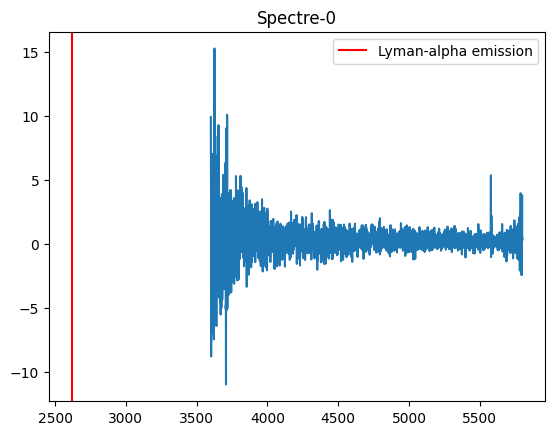

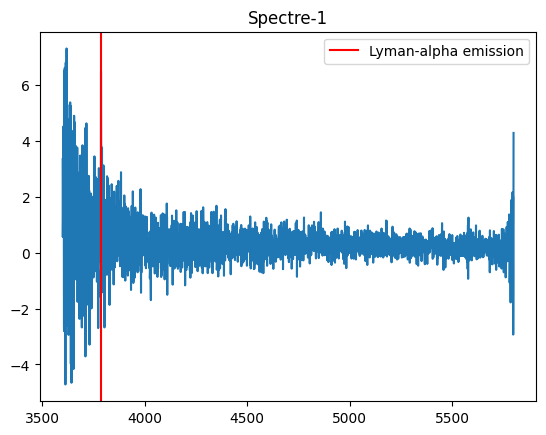

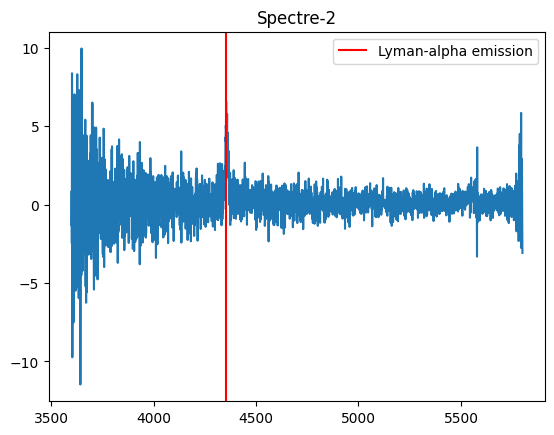

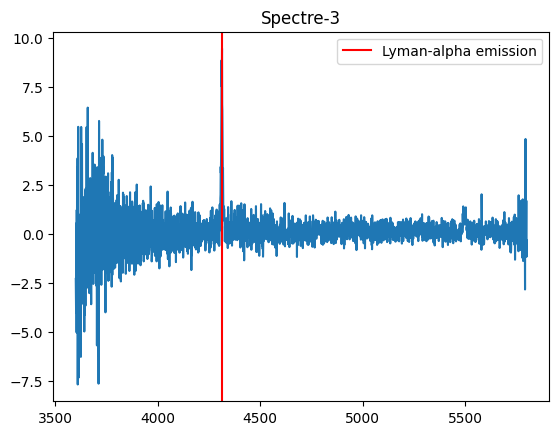

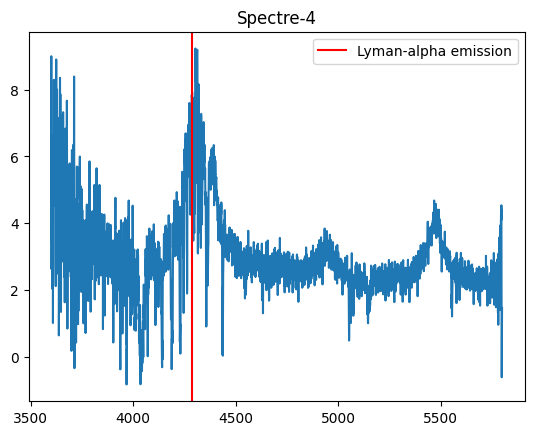

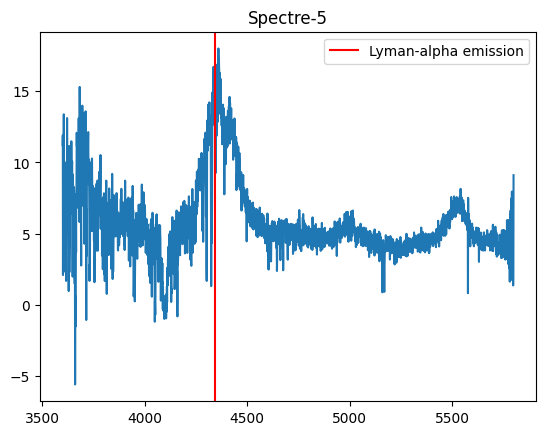

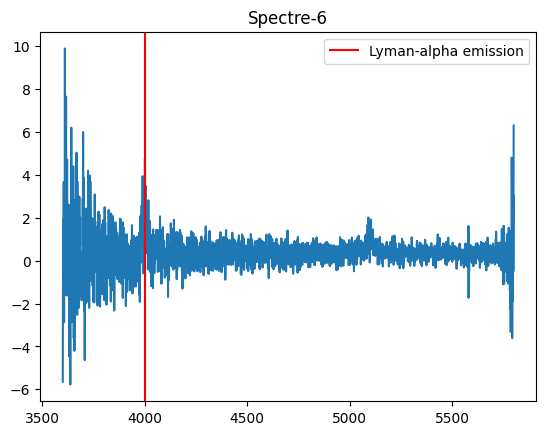

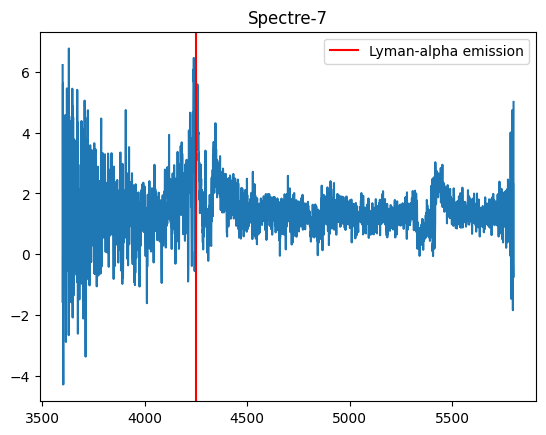

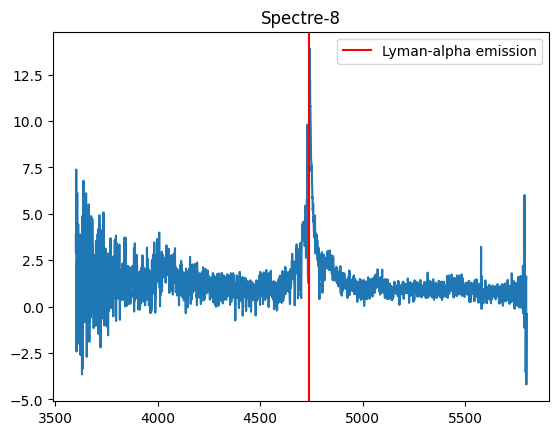

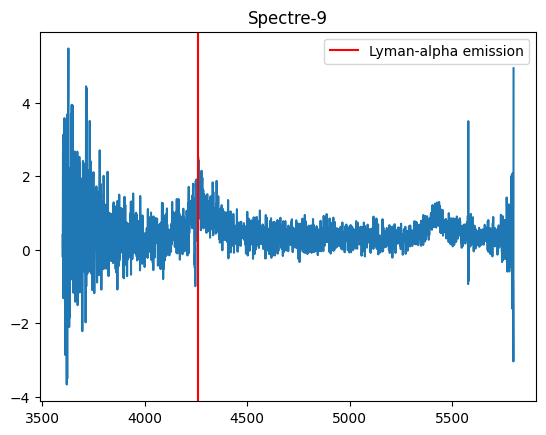

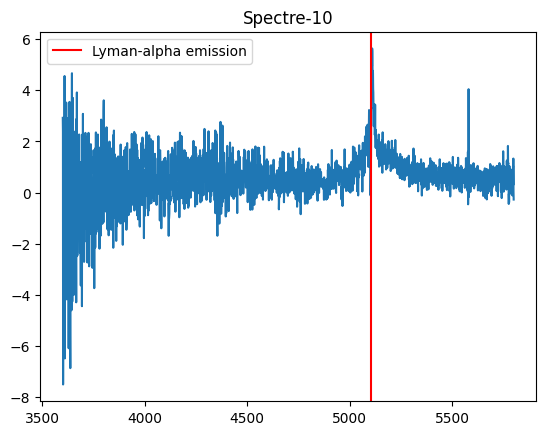

In [14]:
#As we can see we have now a table with only 11 elements, and most of the spectype is of the QSO kind.
#So now we now for a given TARGETID what is the corresponding redshift of the Quasar
# Now lets see if there is agrrement, by ploting the possition of the Lyman-alpha emission
# line for the first 10 elements in the catalog

lya=1216

for i,tid in enumerate(zcat["TARGETID"][:11]):
  z=zcat["Z"][i]
  indx=np.where(tids==tid)[0][0]
  plt.title(f"Spectre-{i}")
  plt.plot(bwave,bflux[indx])
  plt.axvline(1216*(1+z),color='r',label='Lyman-alpha emission')
  plt.legend()
  plt.show()

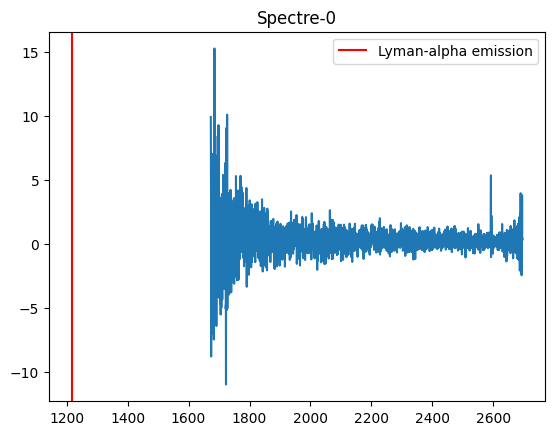

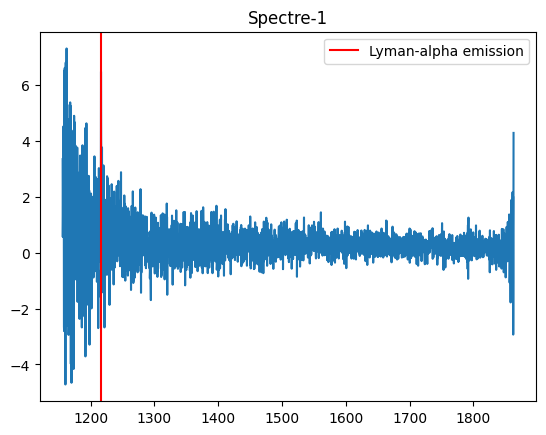

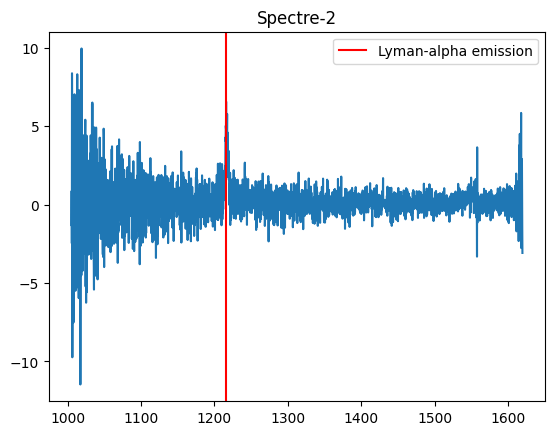

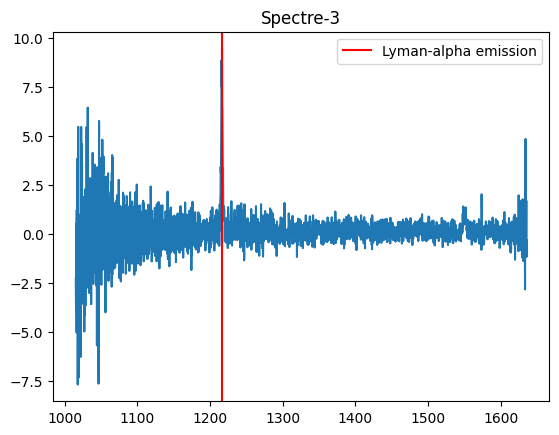

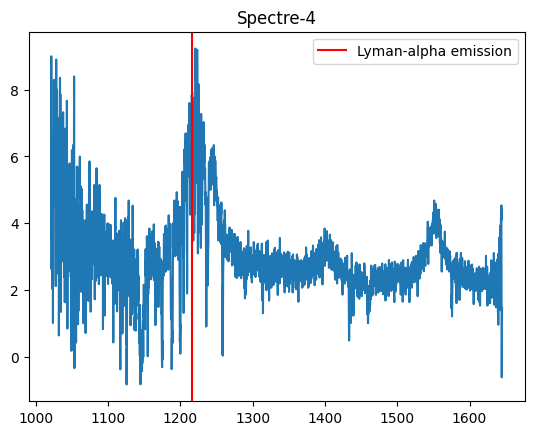

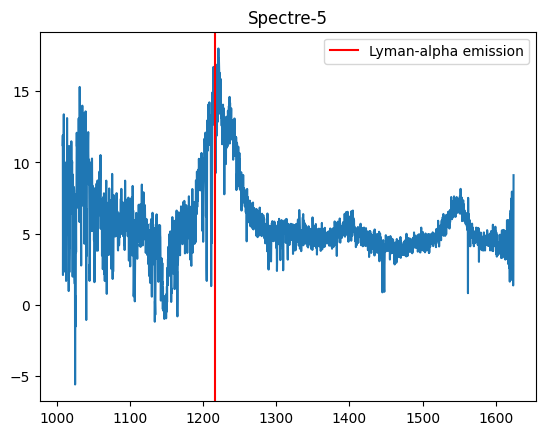

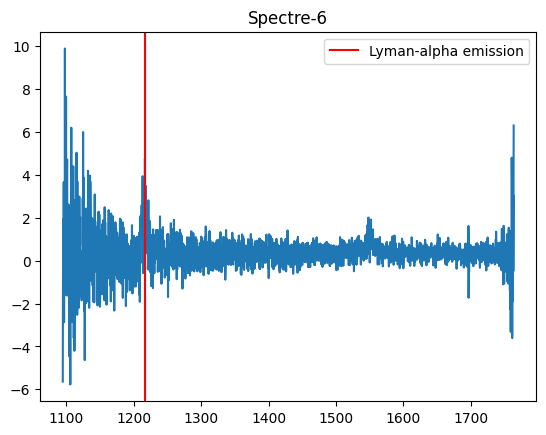

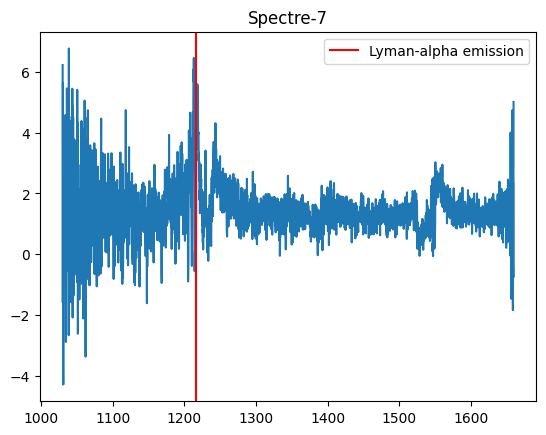

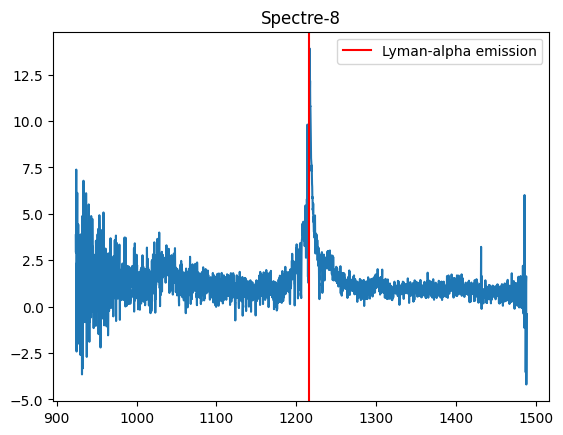

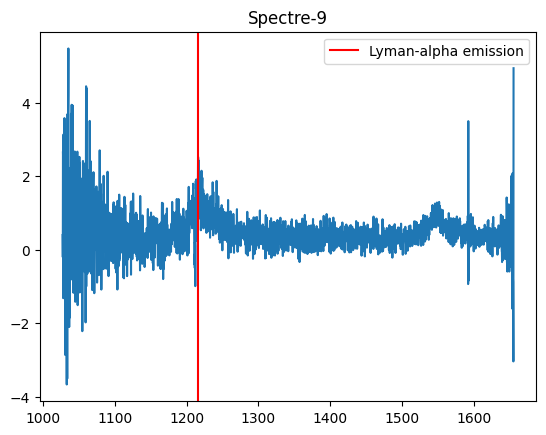

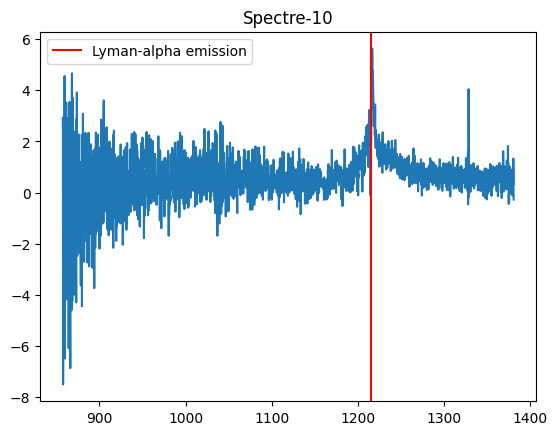

In [15]:
#We can see in most of the cases the position of the redline, which is the expected position of the Lya emission line
#match very well with the position of a strong emission line in the data. So we are confident that we are matching correctly
#the spectra with the quasar redshift.
#No we can convert our spectra from the observed frame to restframe, to do so we need to convert the wavelentgh array
#for each of the spectra to the observed frame using the redhisft.
#Again, here is an example for the first ten spectra
lya=1216

for i,tid in enumerate(zcat["TARGETID"][:11]):
  z=zcat["Z"][i]
  indx=np.where(tids==tid)[0][0]
  plt.title(f"Spectre-{i}")
  plt.plot(bwave/(1+z),bflux[indx])
  plt.axvline(1216,color='red',label='Lyman-alpha emission')
  plt.legend()
  plt.show()

#### Excersise:
 Now that you can convert the spectra to the rest frame,
create a wavelength array in the rest frame that is common for all the spectra, and interpolate de spectra in such array. So that all your spectra have the same wavelenght array as before and you can apply now the PCA analysis.

In [29]:
p=PCA()
p.fit(bflux)
eg_vals = p.explained_variance_ratio_
eg_vals_a = eg_vals.cumsum()
#Eigenvalores
eg_vals_a

array([0.78535212, 0.82867142, 0.8616563 , 0.89328759, 0.92055358,
       0.94260772, 0.9617004 , 0.97863114, 0.99231462, 1.        ,
       1.        ])

In [30]:
#Eigen vectores
eg_vec = p.components_

In [35]:
# Para encontrar los coeficientes de un sólo espectro
coeff = np.dot(eg_vec, bflux[0]-bflux.mean(0))

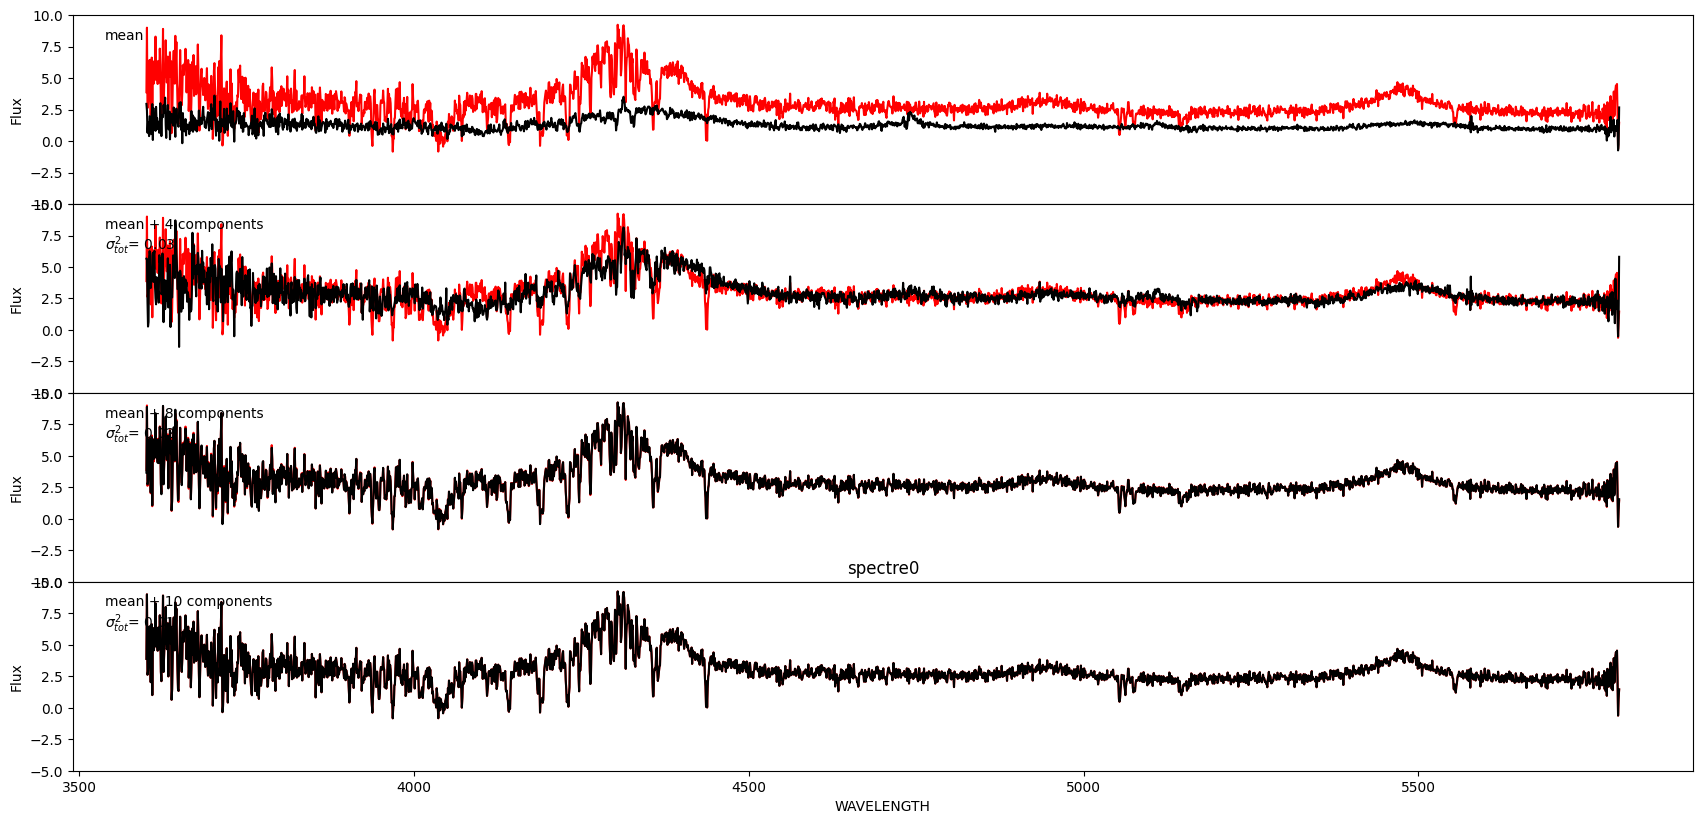

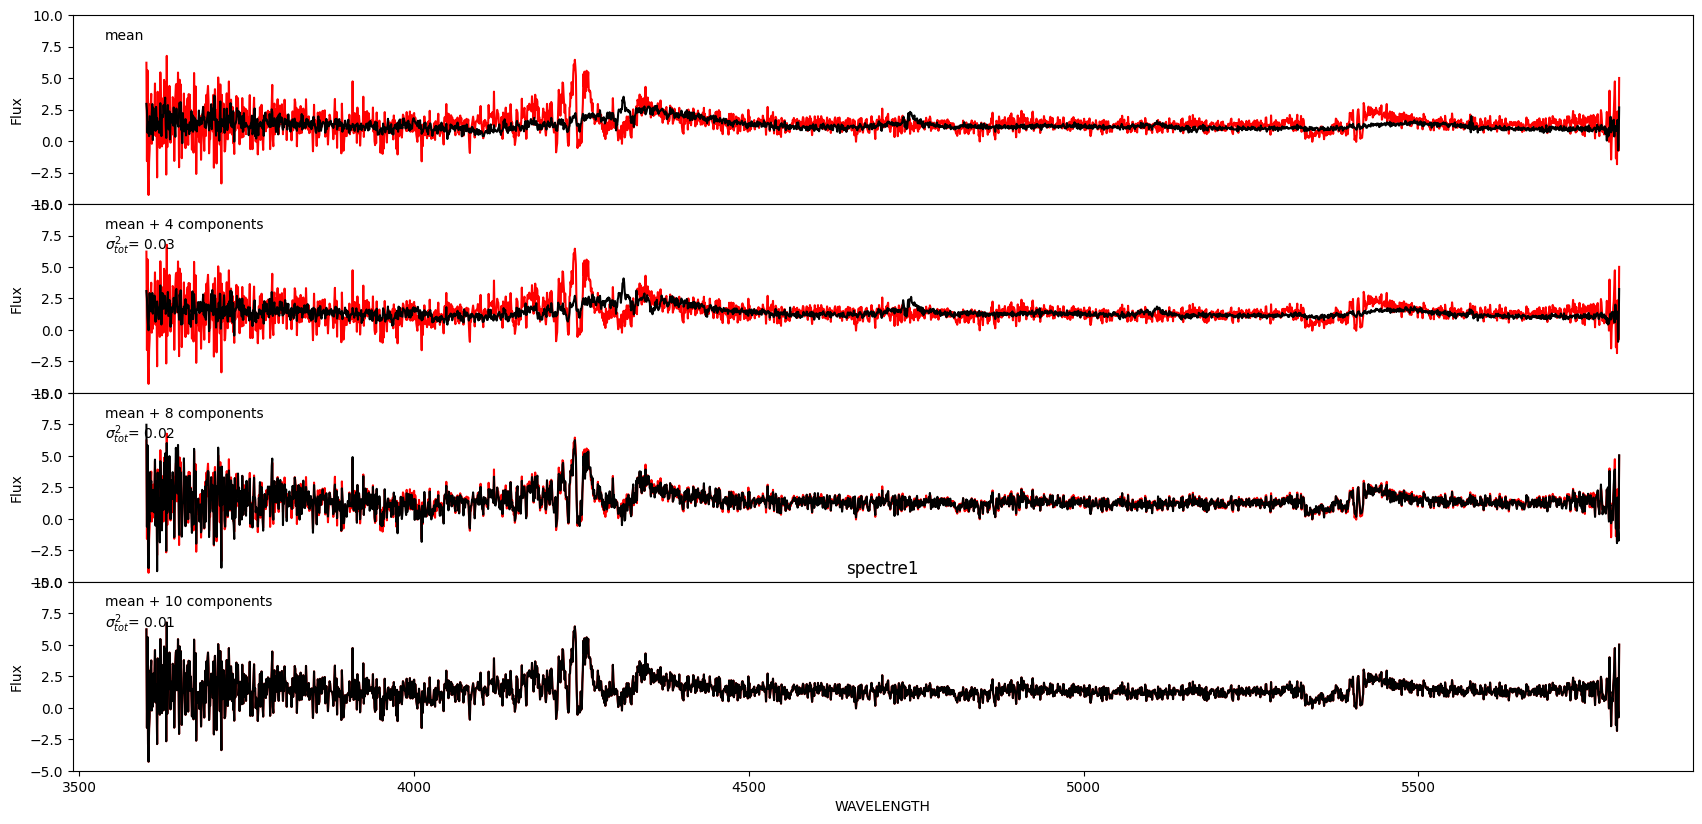

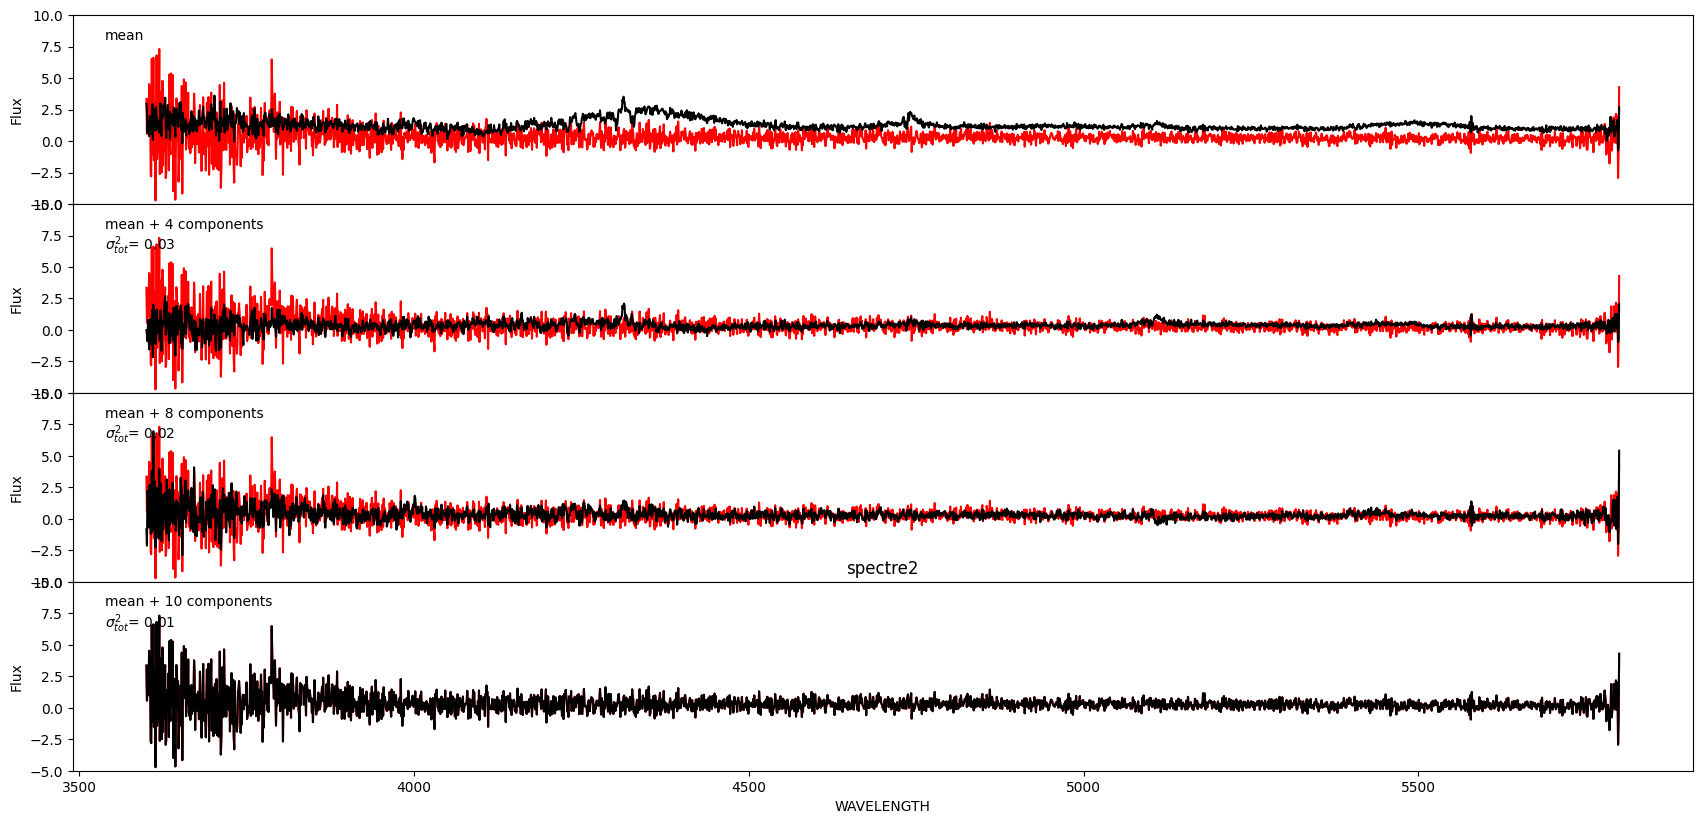

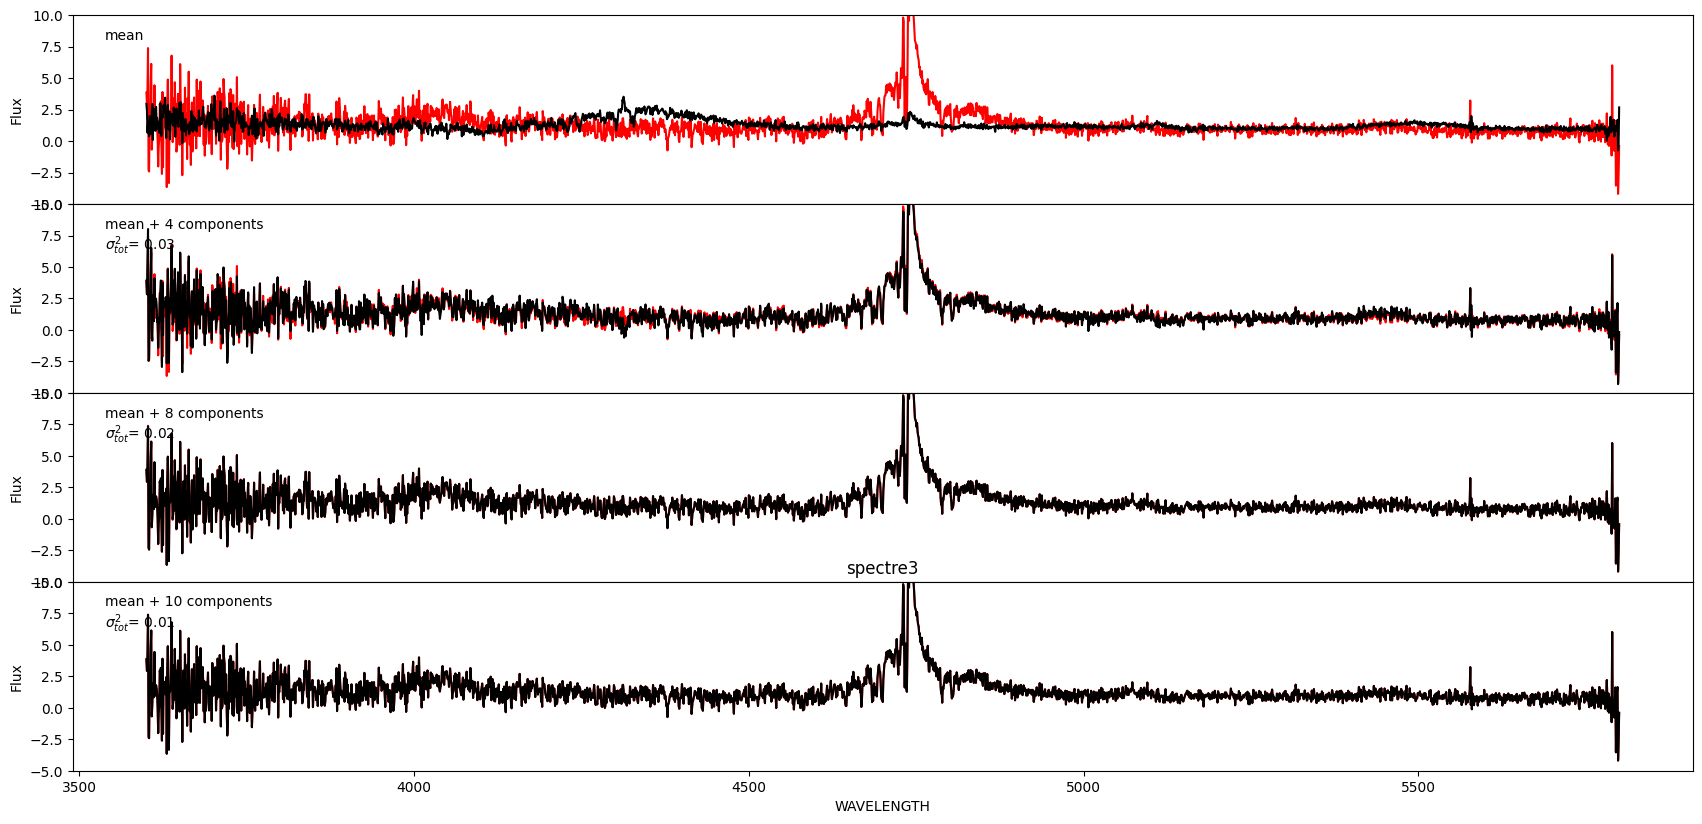

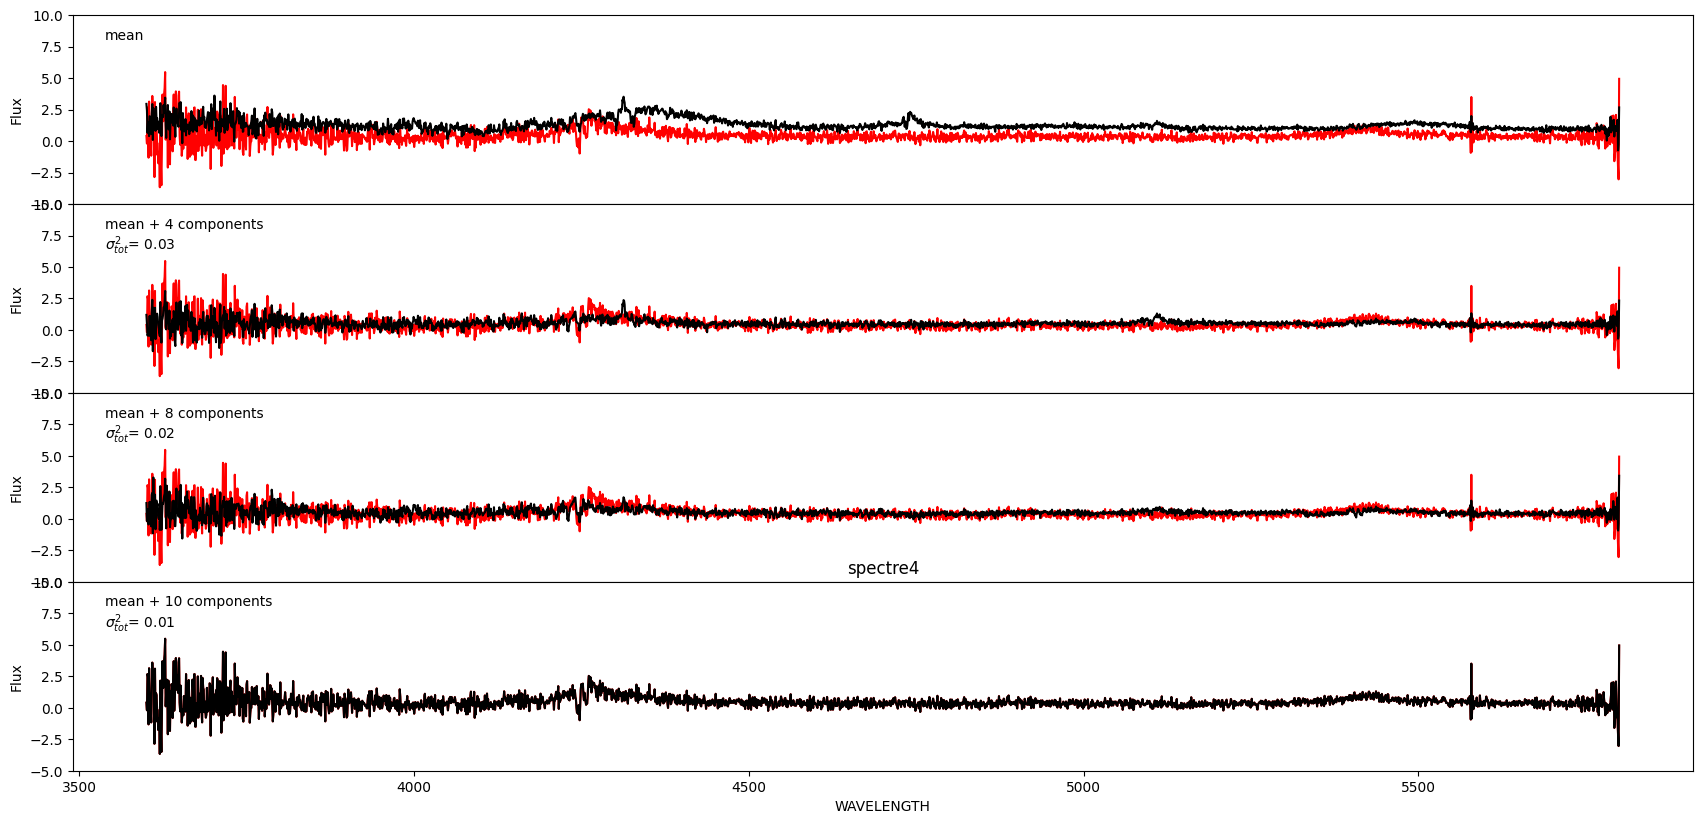

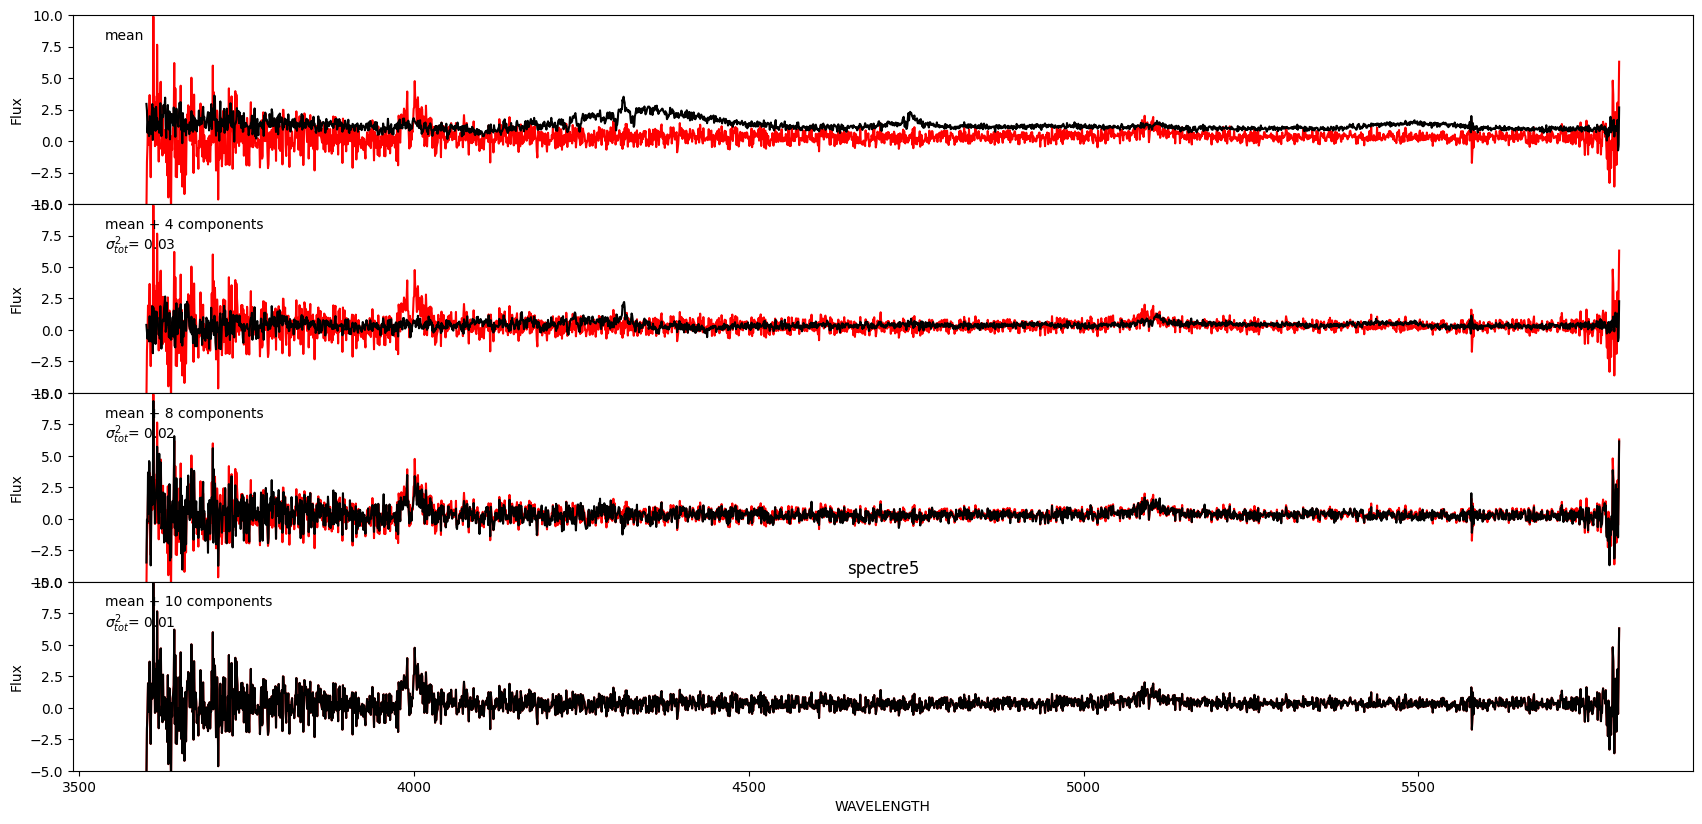

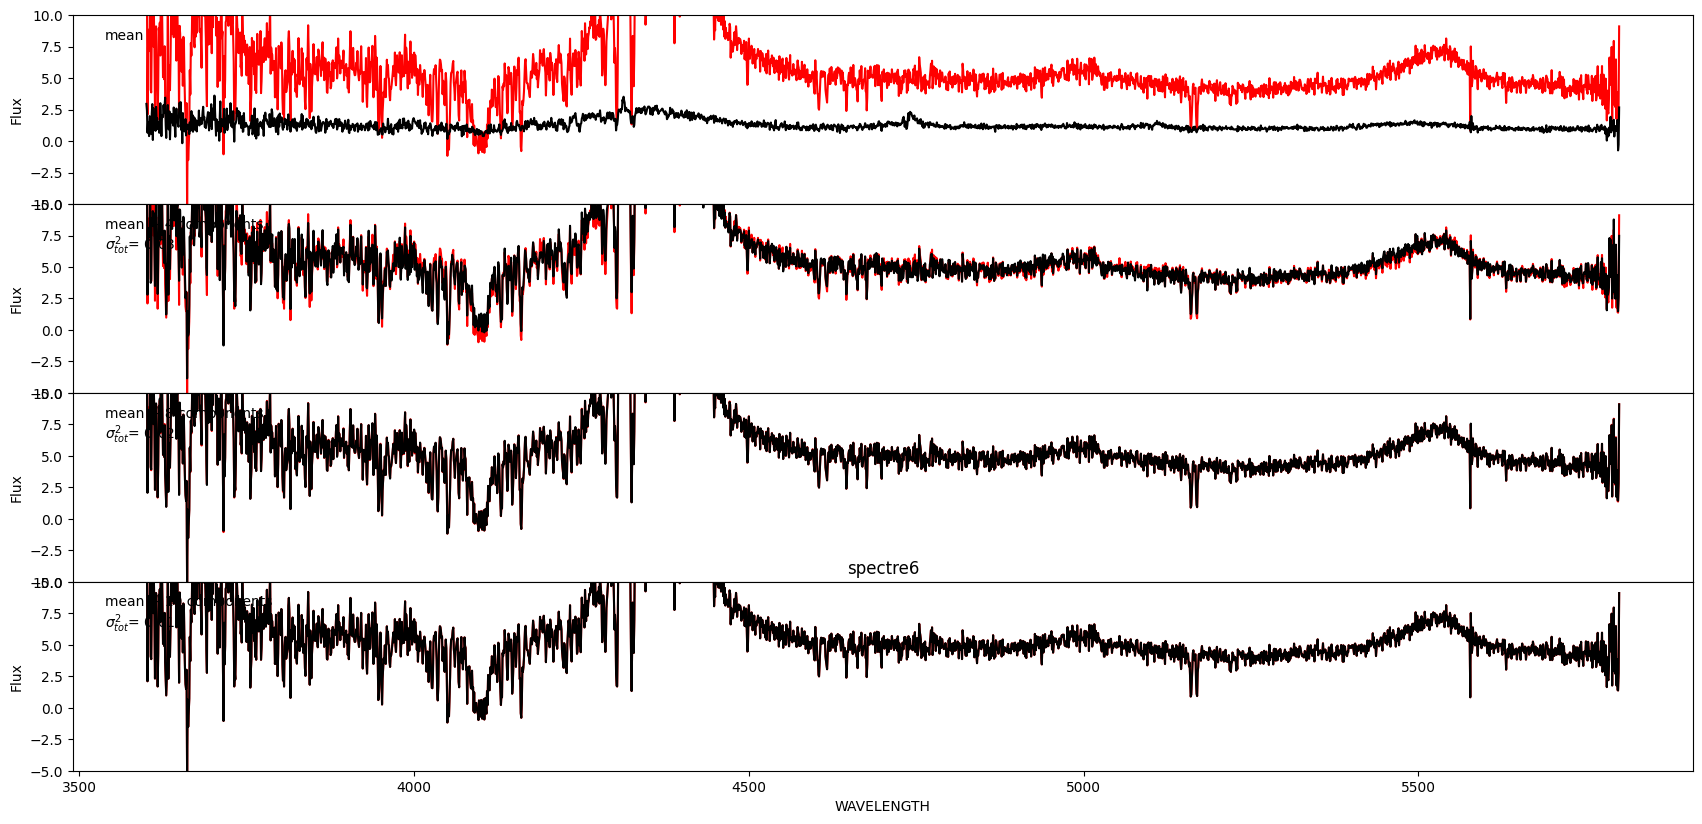

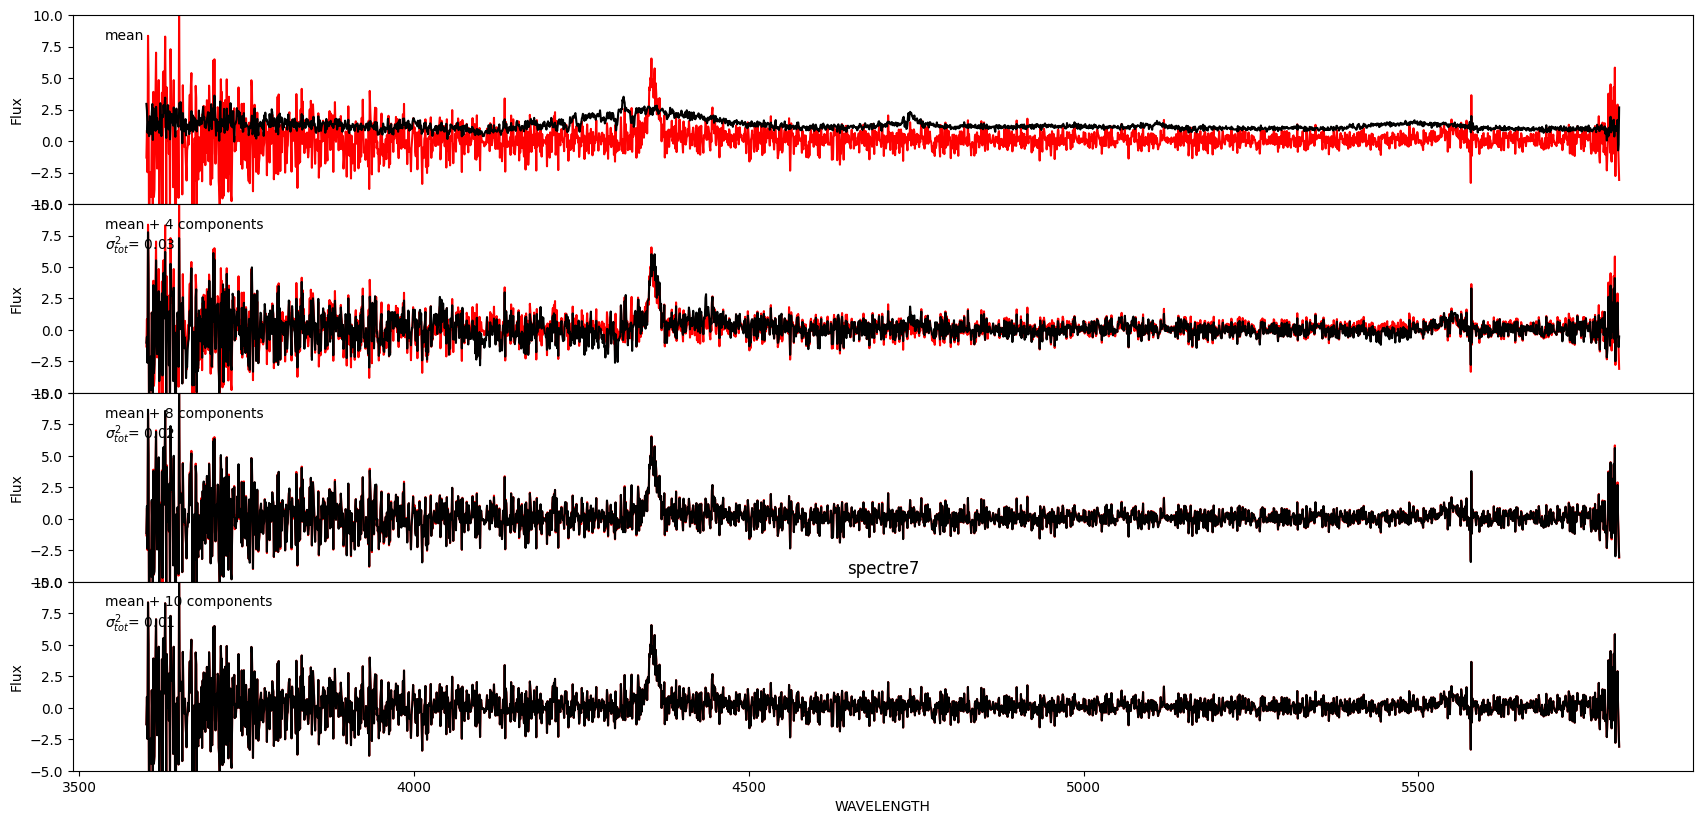

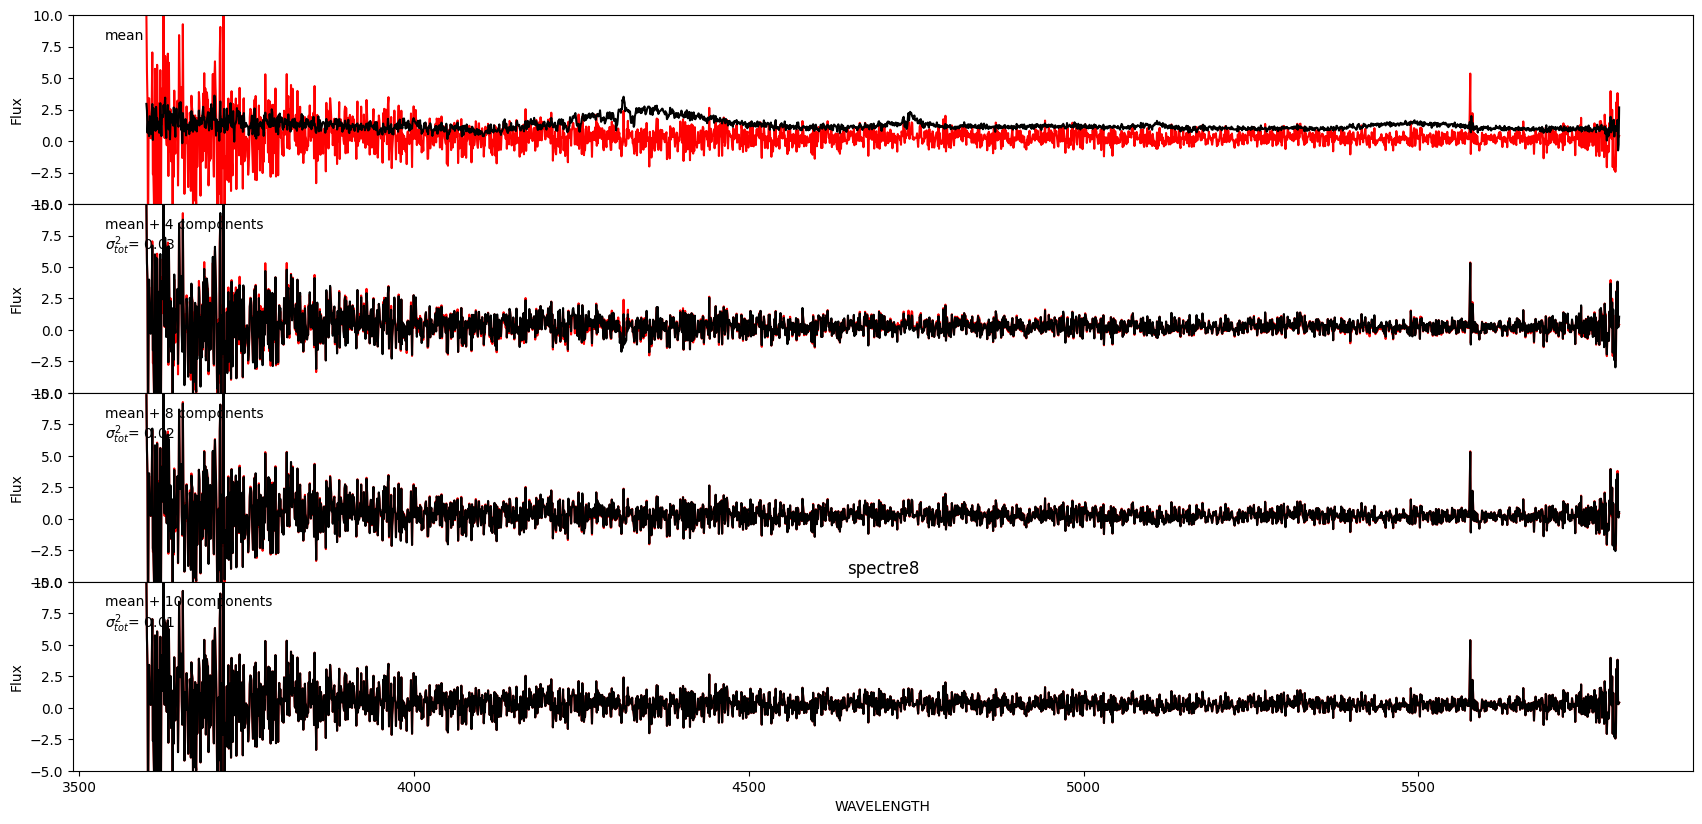

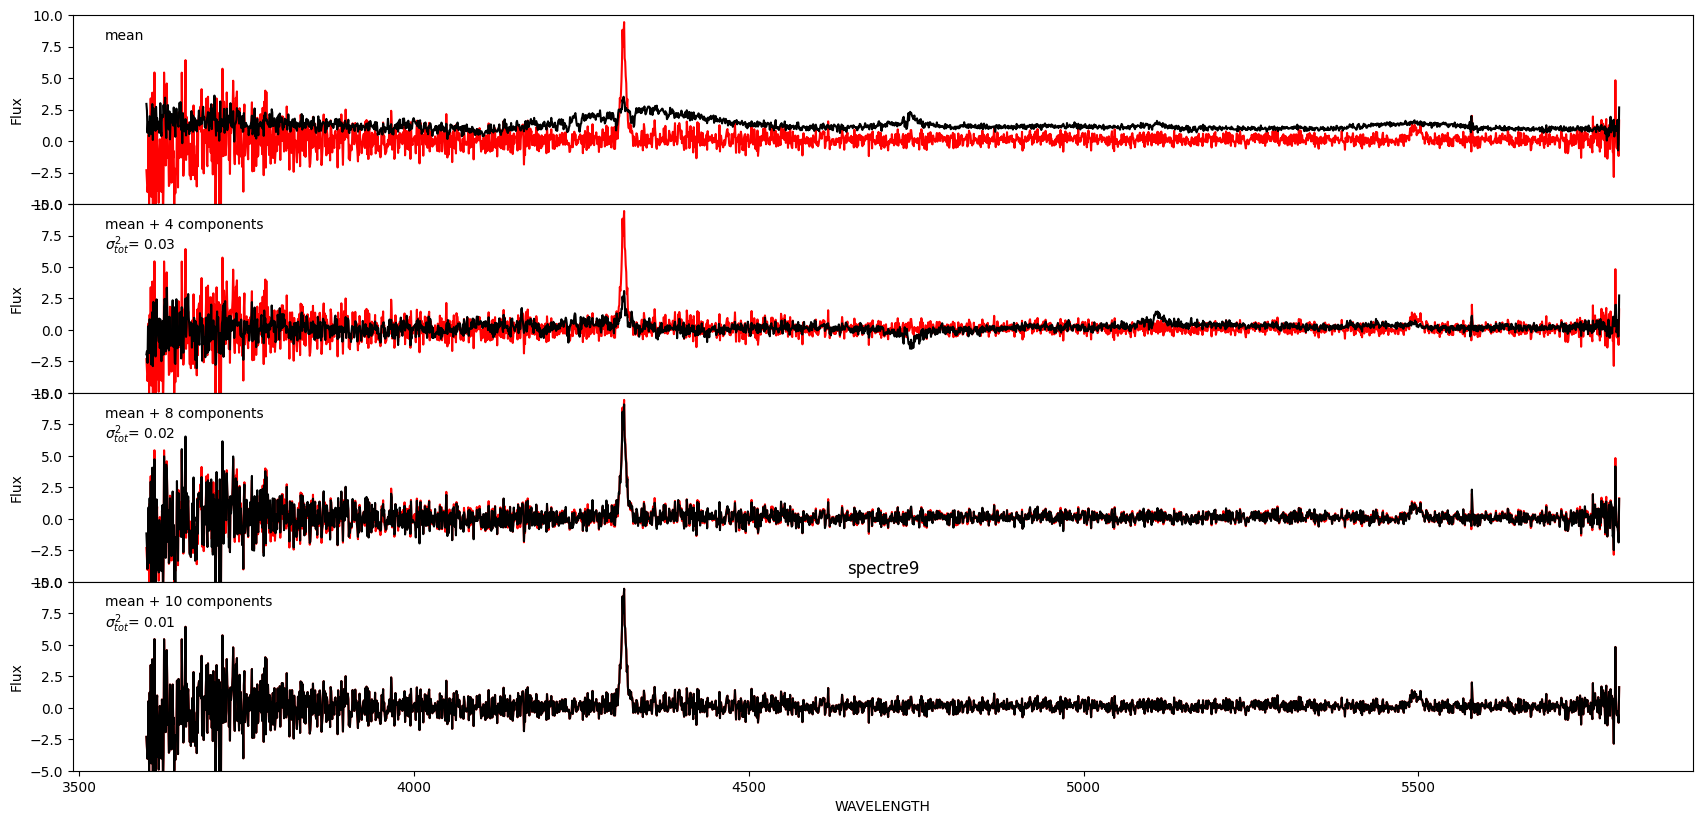

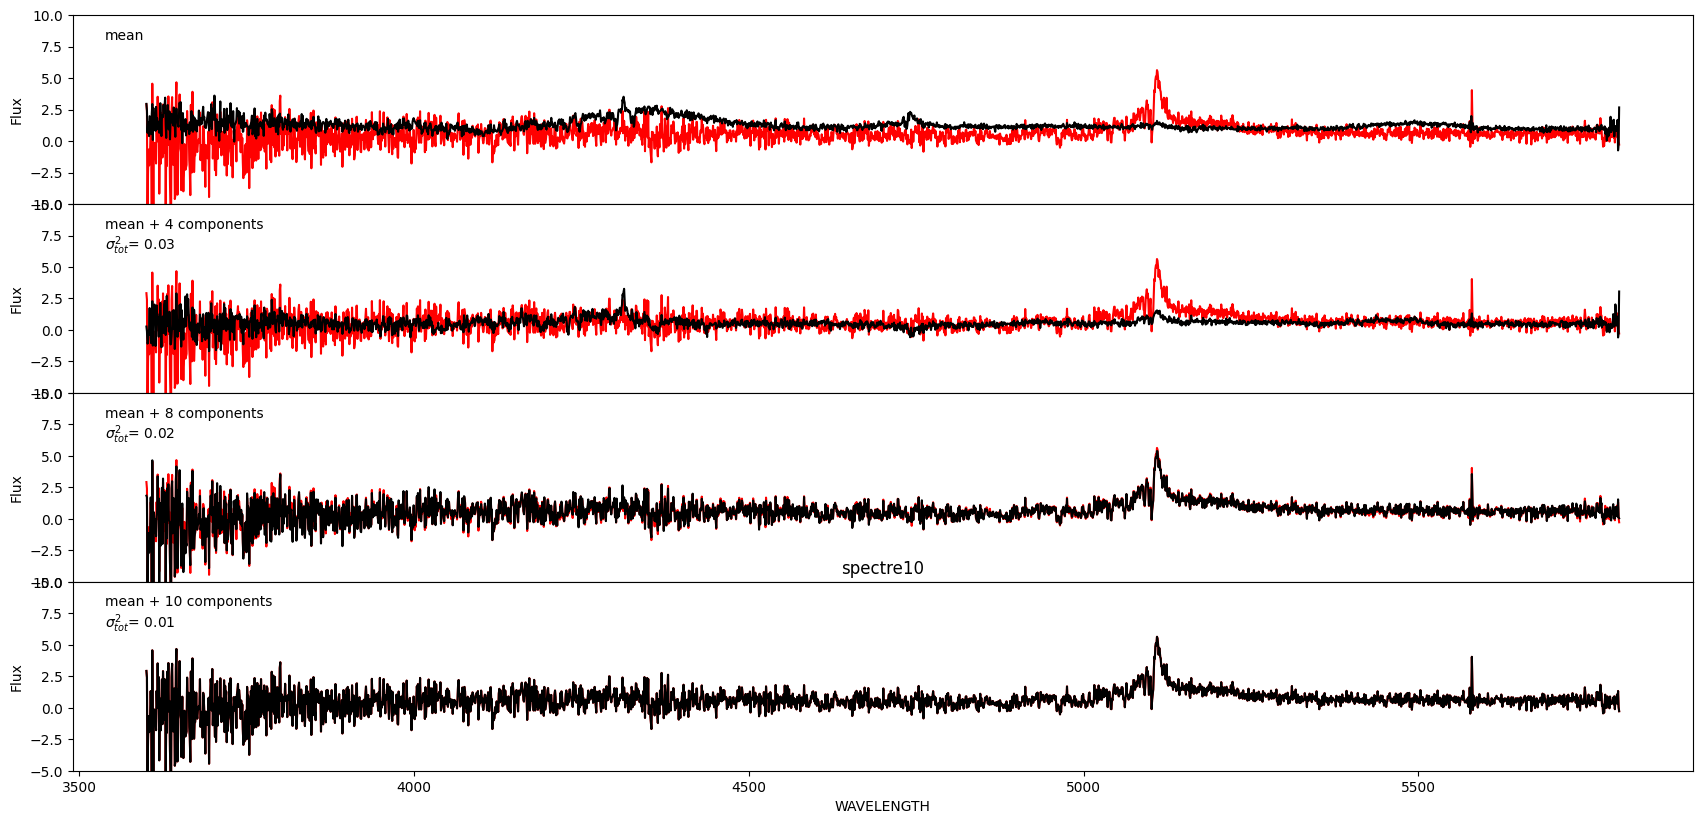

In [67]:
#Imprimimos todos los espectros
for k in range(11):
  coeff = np.dot(eg_vec, bflux[k]-bflux.mean(0)) #Calculamos los coeficientes para cada caso
  fig = plt.figure(figsize=(20, 20))
  fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)
  for i, n in enumerate([0, 4, 8, 10]):
    ax = fig.add_subplot(911 + i)
    ax.plot(bwave,  bflux[k], '-', c='red')
    ax.plot(bwave, bflux.mean(0) + np.dot(coeff[:n], eg_vec[:n]), '-k')
    if i < 3:
       ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylim(-5, 10)
    ax.set_ylabel('Flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + %i components\n" % n
        text += r"$\sigma^2_{tot}$= %.2f" %  eg_vals[n]
    else:
        text = "mean + %i components\n" % n
        text += r"$\sigma^2_{tot}$= %.2f" %  eg_vals[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)
  plt.title(f"spectre{k}")
  fig.axes[-1].set_xlabel (r'WAVELENGTH')
  plt.show()

In [43]:
print(eg_vec.shape)
print(bflux.shape)

(11, 2751)
(11, 2751)
